In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from xgboost import XGBRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error

In [2]:
lob_data= pd.read_csv("C:/Users/keert/OneDrive/Desktop/Mini Project/resampled_lob_secs2.csv")
lob_data['Datetime'] = pd.to_datetime(lob_data['Datetime'])

lob_data['price']=(lob_data['Max Bid Price']*lob_data['Max Bid Quantity']+lob_data['Min Ask Price']*lob_data['Min Ask Quantity'])/(lob_data['Max Bid Quantity']+lob_data['Min Ask Quantity'])
# lob_data

In [3]:
# ofi
def calculate_ofi(df):
    df['delta_bid'] = df['Max Bid Price'].diff().fillna(0)
    df['delta_ask'] = df['Min Ask Price'].diff().fillna(0)
    
        # 计算 ΔW^m(t_n)
    df['delta_w'] = df.apply(
        lambda row: row['Max Bid Quantity'] if row['delta_bid'] > 0 else
                   (-row['Max Bid Quantity'] if row['delta_bid'] < 0 else
                    row['Max Bid Quantity'] - df.loc[df.index[df.index.get_loc(row.name)-1], 'Max Bid Quantity']
                    if row.name > 0 else 0),
        axis=1)
    
    # 计算 ΔV^m(t_n)
    df['delta_v'] = df.apply(
        lambda row: -row['Min Ask Quantity'] if row['delta_ask'] > 0 else
                   (row['Min Ask Quantity'] if row['delta_ask'] < 0 else
                    row['Min Ask Quantity'] - df.loc[df.index[df.index.get_loc(row.name)-1], 'Min Ask Quantity']
                    if row.name > 0 else 0),
        axis=1)
    
    # 计算 OFI
    df['ofi'] = df['delta_w'] + df['delta_v']
    
    return df['ofi']

calculate_ofi(lob_data)
lob_data=lob_data[['Datetime','Min Ask Price','Max Bid Price','price','Total Bid Quantity','Total Ask Quantity','Min Ask Quantity','Max Bid Quantity','ofi']]
# drop the first row (ofi is 0)
lob_data = lob_data.iloc[1:]

In [5]:
def calculate_rsi(data, window):
    """
    计算给定数据的相对强弱指数（RSI）。
    
    :param data: 包含价格数据的Pandas Series。
    :param window: 用于计算RSI的窗口大小，默认为14。
    :return: 包含RSI值的Pandas Series。
    """
    delta = data.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()

    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

lob_data['RSI'] = calculate_rsi(lob_data['price'], window=5) # calculate RSI
lob_data['MA'] = lob_data['price'].rolling(window=5).mean() # Cclculate moving avg
lob_data['Momentum'] = lob_data['price'] - lob_data['price'].shift(5) # Calculate momentum
# lob_data.head()

In [6]:
# This is only for trading volume, not for modeling
# # 设置一个时间窗口
rolling_window = 5  # 例如，我们使用过去5个时间点的数据来计算波动率

# 计算对数收益率 shift(1)是为了计算相对于前一分钟的收益率
lob_data['Log Return Max Bid'] = np.log(lob_data['Max Bid Price'] / lob_data['Max Bid Price'].shift(1))
lob_data['Log Return Min Ask'] = np.log(lob_data['Min Ask Price'] / lob_data['Min Ask Price'].shift(1))

# 计算滚动标准差作为波动率的度量
lob_data['Volatility Max Bid'] = lob_data['Log Return Max Bid'].rolling(window=rolling_window).std()
lob_data['Volatility Min Ask'] = lob_data['Log Return Min Ask'].rolling(window=rolling_window).std()

# 由于滚动计算会产生缺失值，我们通常会删除这些值
# lob_data.dropna(inplace=True)

# Trading volume
def adjust_trade_quantity(volatility, max_tradeable_quantity, base_quantity=1, risk_tolerance=0.5, scaler_fator=10):
    """
    根据波动率和最大可交易量调整交易量。
    volatility: 当前波动率
    max_tradeable_quantity: 该时间点的最大可交易量（对于买入操作，是Min Ask Quantity；对于卖出操作，是Max Bid Quantity）
    base_quantity: 基础交易量
    risk_tolerance: 风险容忍度，取值范围为[0, 1]，数值越小表风险承受越大，交易量越大
    """
    # 基于波动率调整的交易量
    adjusted_quantity = base_quantity / (volatility*risk_tolerance*scaler_fator)
    adjusted_quantity = max(1, round(adjusted_quantity))  # 确保至少交易1单位，并且是整数

    # 确保交易量不超过最大可交易量 make sure the trade quantity is no more than the max tradeable quantity
    final_trade_quantity = min(adjusted_quantity, max_tradeable_quantity)

    return final_trade_quantity

In [7]:
# split data
lob_data.columns

Index(['Datetime', 'Min Ask Price', 'Max Bid Price', 'price',
       'Total Bid Quantity', 'Total Ask Quantity', 'Min Ask Quantity',
       'Max Bid Quantity', 'ofi', 'RSI', 'MA', 'Momentum',
       'Log Return Max Bid', 'Log Return Min Ask', 'Volatility Max Bid',
       'Volatility Min Ask'],
      dtype='object')

In [8]:
# drop na
lob_data.dropna(inplace=True)

# split data
split_index = int(0.8 * len(lob_data))
features = ['Total Bid Quantity', 'Total Ask Quantity', 'Min Ask Quantity', 'Max Bid Quantity', 'ofi', 'RSI', 'MA', 'Momentum']
target = 'price'
X_train, X_test = lob_data[features][:split_index], lob_data[features][split_index:]
y_train, y_test = lob_data[target][:split_index], lob_data[target][split_index:]

In [9]:
lob_data

,Datetime,Min Ask Price,Max Bid Price,price,Total Bid Quantity,Total Ask Quantity,Min Ask Quantity,Max Bid Quantity,ofi,RSI,MA,Momentum,Log Return Max Bid,Log Return Min Ask,Volatility Max Bid,Volatility Min Ask
6,2025-01-02 00:00:08,276,266,268.500000,30,19,2,6,2,43.387152,269.589177,-1.250000,0.000000,-0.010811,0.003178,0.005673
7,2025-01-02 00:00:09,271,266,266.714286,33,21,1,6,1,23.432420,268.598701,-4.952381,0.000000,-0.018282,0.002067,0.004778
8,2025-01-02 00:00:10,269,267,267.333333,33,22,1,5,6,20.439189,267.538095,-5.303030,0.003752,-0.007407,0.002063,0.004808
9,2025-01-02 00:00:11,270,267,268.714286,41,22,4,3,-6,64.285714,267.823810,1.428571,0.000000,0.003711,0.002059,0.007935
10,2025-01-02 00:00:12,270,267,268.500000,41,20,3,3,-1,56.923077,267.952381,0.642857,0.000000,0.000000,0.001678,0.008728
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3767279,2025-07-01 08:17:55,183,109,133.666667,21,18,1,2,-1,79.558011,124.390476,35.666667,0.000000,0.079587,0.245207,0.527348
3767280,2025-07-01 08:17:56,183,110,128.250000,24,18,1,3,3,81.702128,131.840476,37.250000,0.009132,0.000000,0.232822,0.527348
3767281,2025-07-01 08:17:57,123,110,114.333333,26,18,1,2,0,34.012739,129.450000,-11.952381,0.000000,-0.397302,0.178868,0.197025
3767282,2025-07-01 08:17:58,114,109,111.500000,25,19,1,1,0,20.289855,125.350000,-20.500000,-0.009132,-0.075986,0.039077,0.189979


In [4]:
## XGBoost to predict future prices:

In [10]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Load your dataset
# data = pd.read_csv('path_to_lob_data.csv')  # Uncomment if you're loading data from a CSV file

# Selecting features
features = ['Min Ask Price', 'Max Bid Price', 'Total Bid Quantity', 'Total Ask Quantity', 
            'Min Ask Quantity', 'Max Bid Quantity', 'ofi', 'RSI', 'MA', 
            'Momentum', 'Log Return Max Bid', 'Log Return Min Ask', 
            'Volatility Max Bid', 'Volatility Min Ask']
target = 'price'

# Assuming 'lob_data' is already loaded as shown in your snippet
X = lob_data[features]
y = lob_data[target]

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [11]:
# Splitting the data into training and testing sets
train_size = int(len(X) * 0.8)
X_train_scaled, X_test_scaled = X_scaled[:train_size], X_scaled[train_size:]
y_train, y_test = y[:train_size], y[train_size:]


In [12]:
from xgboost import XGBRegressor

# Create and fit the model
xgb_model = XGBRegressor(objective='reg:squarederror', n_estimators=300, max_depth=5, learning_rate=0.1, random_state=42)
xgb_model.fit(X_train_scaled, y_train)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=300, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

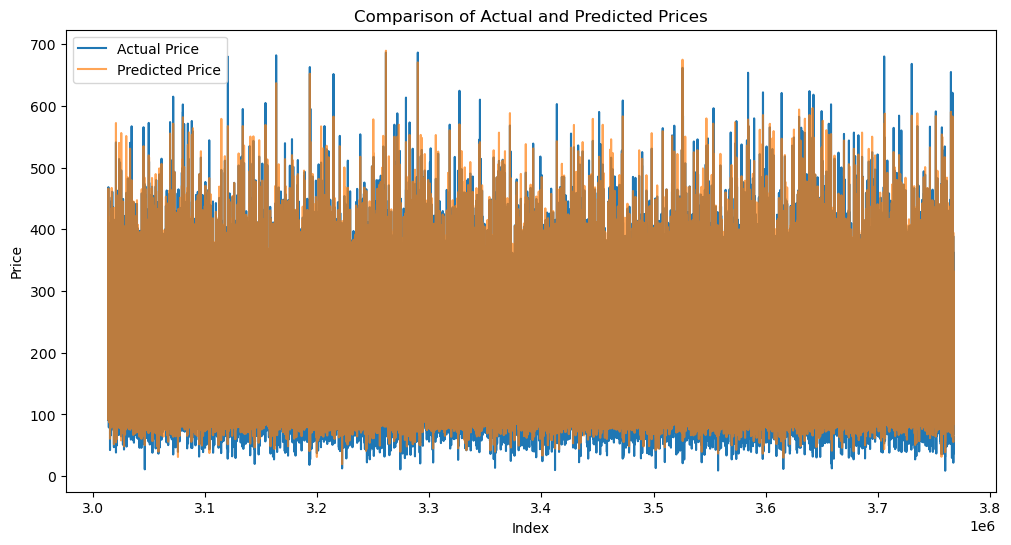

In [13]:
# Making predictions
y_pred_xgb = xgb_model.predict(X_test_scaled)

# Compare predicted and actual values
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(y_test.index, y_test, label='Actual Price')
plt.plot(y_test.index, y_pred_xgb, label='Predicted Price', alpha=0.7)
plt.title('Comparison of Actual and Predicted Prices')
plt.xlabel('Index')
plt.ylabel('Price')
plt.legend()
plt.show()


In [14]:
from sklearn.metrics import mean_squared_error, r2_score

mse = mean_squared_error(y_test, y_pred_xgb)
r2 = r2_score(y_test, y_pred_xgb)
print(f"Mean Squared Error: {mse}")
print(f"R^2 Score: {r2}")


Mean Squared Error: 30.824509993123275
R^2 Score: 0.9833150094083568


In [15]:

# Generate signals based on the prediction

signals = np.where(y_pred_xgb[:-1] > y_test[:-1], 1, -1)  # 1 for Buy, -1 for Sell


In [21]:
def trading_simulator(prices, signals, initial_capital=10000, max_capital=float('inf')):
    capital = initial_capital
    position = 0
    current_hold_value = 0
    capital_history = [capital]
    
    for i in range(1, len(signals)):
        if np.isnan(signals[i]) or np.isnan(prices[i]):
            continue
        
        if signals[i] == 1 and capital >= prices[i]:  # Buy signal
            if capital > max_capital:
                # Reset or redistribute capital if it's unrealistically high
                capital = max_capital
            num_shares_to_buy = capital // prices[i]
            capital -= num_shares_to_buy * prices[i]
            position += num_shares_to_buy

        elif signals[i] == -1 and position > 0:  # Sell signal
            capital += position * prices[i]
            position = 0
            if capital > max_capital:
                # Reset or redistribute capital if it's unrealistically high
                capital = max_capital

        current_hold_value = position * prices[i] if position > 0 else 0
        capital_history.append(capital + current_hold_value)
        
        if np.isnan(capital) or np.isnan(position):
            print(f"NaN detected at step {i}, capital: {capital}, position: {position}")


    final_portfolio_value = capital + current_hold_value
    profit = final_portfolio_value - initial_capital
    return profit, capital_history

In [22]:
# Use the last known price for each day as the price for trading

# Assuming a realistic max capital ceiling
max_capital = 1e8  # For example, $100 million
profit, capital_history = trading_simulator(prices, signals, initial_capital=10000, max_capital=max_capital)



print(f"Final profit from trading simulation: ${profit:.2f}")


Final profit from trading simulation: $7241900.60


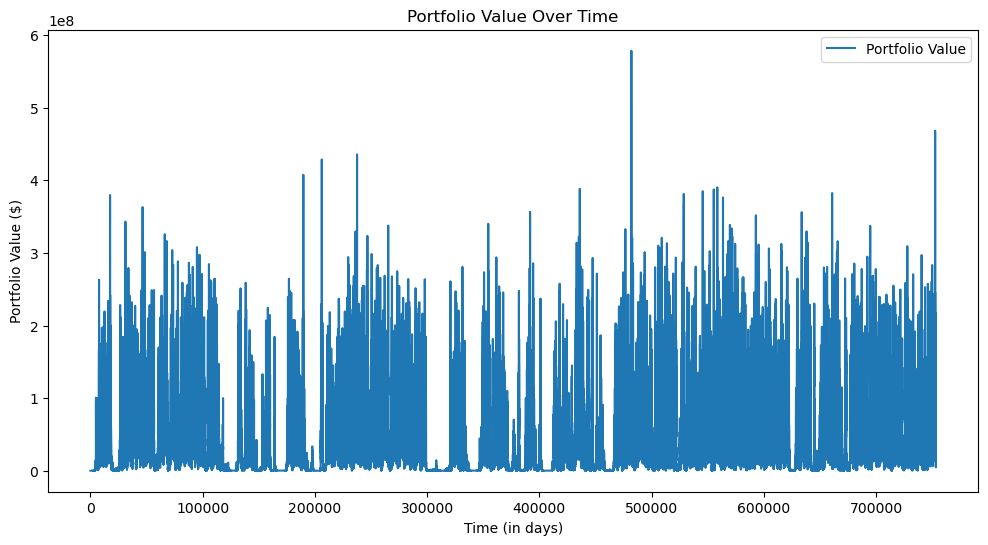

In [23]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(capital_history, label='Portfolio Value')
plt.title('Portfolio Value Over Time')
plt.xlabel('Time (in days)')
plt.ylabel('Portfolio Value ($)')
plt.legend()
plt.show()

In [24]:
initial_capital = 10000
final_profit = 7241900.60

percentage_profit = (final_profit / initial_capital) * 100

print(f"Percentage of profit made: {percentage_profit:.2f}%")


Percentage of profit made: 72419.01%


In [27]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Assuming 'lob_data' is your DataFrame
features = ['Min Ask Price', 'Max Bid Price', 'Total Bid Quantity', 'Total Ask Quantity', 
            'Min Ask Quantity', 'Max Bid Quantity', 'ofi', 'RSI', 'MA', 'Momentum', 
            'Log Return Max Bid', 'Log Return Min Ask', 'Volatility Max Bid', 'Volatility Min Ask']
target = 'price'

X = lob_data[features]
y = lob_data[target]

# Scaling features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Splitting the dataset
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, shuffle=False)


In [28]:
from xgboost import XGBRegressor

xgb_model = XGBRegressor(objective='reg:squarederror', n_estimators=300, max_depth=5, learning_rate=0.1, random_state=42)
xgb_model.fit(X_train, y_train)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=300, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [49]:
# Predicting future prices
y_pred = xgb_model.predict(X_test)

# Generating trading signals: buy if the predicted future price is higher than the current price

# Assuming y_pred and prices are available from your model's output
buffer = 0.02  # 2% buffer to avoid market noise
signals = [1 if (y_pred[i+1] - prices[i]) / prices[i] > buffer else -1 if (y_pred[i+1] - prices[i]) / prices[i] < -buffer else 0 for i in range(len(prices)-1)]



In [54]:
def generate_signals(actual_prices, predicted_prices, buffer=0.03):
    """
    Generate trading signals based on predicted and actual prices.
    A buffer is used to create a threshold for generating signals to avoid trading on minor price movements.
    
    Parameters:
        actual_prices (array): The array of actual prices.
        predicted_prices (array): The array of prices predicted by the model.
        buffer (float): Percentage buffer to reduce trading noise.

    Returns:
        signals (array): An array of trading signals (1 for buy, -1 for sell, 0 for hold).
    """
    signals = []
    for i in range(len(actual_prices) - 1):
        if (predicted_prices[i+1] - actual_prices[i]) / actual_prices[i] > buffer:
            signals.append(1)  # Buy signal
        elif (predicted_prices[i+1] - actual_prices[i]) / actual_prices[i] < -buffer:
            signals.append(-1)  # Sell signal
        else:
            signals.append(0)  # Hold signal
    # Append 0 for the last element as we cannot have a signal without a future price
    signals.append(0)
    return signals


In [60]:
def trading_simulator(prices, signals,initial_capital=10000, max_capital=100000, transaction_cost_rate=0.0005, stop_loss=0.05, take_profit=0.10):
    capital = initial_capital
    position = 0
    current_hold_value = 0
    capital_history = [capital]
    
    for i in range(1, len(signals)):
        print(f"Step {i}, Signal: {signals[i]}, Price: {prices[i]}, Capital: {capital}, Position: {position}")

        if signals[i] == 1:  # Buy signal
            if capital >= prices[i]:
                num_shares_to_buy = capital // prices[i]
                capital -= num_shares_to_buy * prices[i]
                position += num_shares_to_buy
                print(f"Bought {num_shares_to_buy} shares.")

        elif signals[i] == -1:  # Sell signal
            if position > 0:
                capital += position * prices[i]
                position = 0
                print(f"Sold all shares, new capital: {capital}")

        current_hold_value = position * prices[i] if position > 0 else 0
        capital_history.append(capital + current_hold_value)

    final_portfolio_value = capital + current_hold_value
    profit = final_portfolio_value - initial_capital
    return profit, capital_history


In [67]:
def trading_simulator(prices, signals, initial_capital=10000, max_capital=100000, transaction_cost_rate=0.001, stop_loss=0.03, take_profit=0.05):
    capital = initial_capital
    position = 0
    capital_history = []
    purchase_price = None  # Initialize purchase price

    for i in range(len(prices)):
        price = prices[i]
        signal = signals[i]
        
        # Safety checks
        if np.isnan(price) or np.isinf(price):
            continue  # Skip iteration if price is NaN or infinite

        if signal == 1 and capital >= price:  # Buy signal
            shares_to_buy = (capital * (1 - transaction_cost_rate)) // price
            if shares_to_buy > 0:
                capital -= shares_to_buy * price
                position += shares_to_buy
                purchase_price = price

        elif position > 0 and (signal == -1 or i == len(prices) - 1):  # Sell signal or last iteration
            capital += position * price
            position = 0
            purchase_price = None
        
        # Stop-loss and take-profit logic
        if purchase_price is not None and position > 0:
            profit_ratio = (price - purchase_price) / purchase_price
            if profit_ratio <= -stop_loss or profit_ratio >= take_profit:
                capital += position * price
                position = 0
                purchase_price = None

        # Ensure capital does not exceed max_capital
        capital = min(capital, max_capital)
        capital_history.append(capital + position * price if position > 0 else capital)

    final_portfolio_value = capital + position * prices[-1] if position > 0 else capital
    profit = final_portfolio_value - initial_capital
    return profit, capital_history


In [68]:
prices = y_test.values  # Assuming y_test contains the actual prices
signals = generate_signals(prices, y_pred, buffer=0.05)  # Ensure this function is properly defined
profit, capital_history = trading_simulator(prices, signals, initial_capital=10000, max_capital=100000, transaction_cost_rate=0.001)
print(f"Final profit from trading simulation: ${profit:.2f}")


Final profit from trading simulation: $90000.00


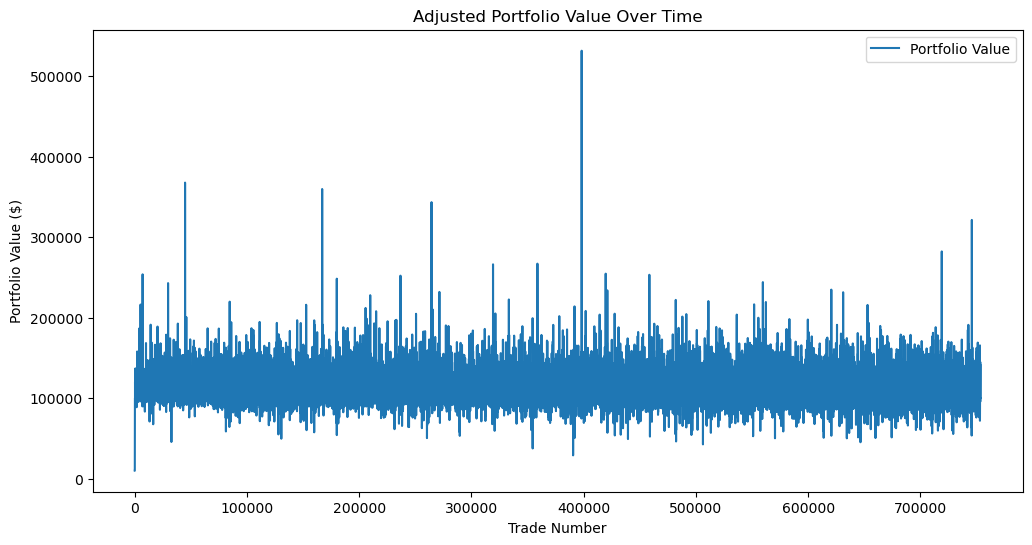

In [69]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(capital_history, label='Portfolio Value')
plt.title('Adjusted Portfolio Value Over Time')
plt.xlabel('Trade Number')
plt.ylabel('Portfolio Value ($)')
plt.legend()
plt.show()
